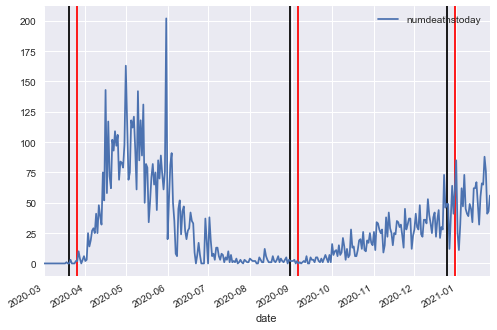

In [121]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
#------Data prep and visialisation of the whole data-------------
# The goal of this part is to prepare the data and to visualise
# the data I will work with
#----------------------------------------------------------------


# The Url where I dowload the data 
url='https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv'

#reading + preparing the data
df = pd.read_csv(url, parse_dates=True)

#getting the Quebec data 
df=df.loc[df.prname=='Quebec']

#Making the date data into a datetime
df['date']=pd.to_datetime(df['date'])

#---- the important dates-----------------
#1. The 20/3/2020 lockdown
#2. The reopening of schools on 31/8/2020
#3. The 25/12/2020 lockdown 2
#------------------------------------------

# the column from the original data frama I will work with
col= 'numdeathstoday'

# getting the columns of the original df that I will use 
df1=df[['date',col]]

#making the index as the data 
df1.index=df1['date']

df1=df1.drop('date',axis=1)

#Since no data was entered the 25th of december, I added the data from the
#26th and divide it by 2, I have that same value for the 26th 
df1.loc[df1.index=='2020-12-25']=df1[col].loc[df1.index=='2020-12-26'].values/2
df1.loc[df1.index=='2020-12-26']=df1[col].loc[df1.index=='2020-12-26'].values/2

# ------ Visualisation  of the data -------------------------
fig, ax = plt.subplots()
plt.style.use('seaborn')
df1.plot(ax=ax)
ax.legend([col],loc='best')
ax.set_yscale('linear')

ymin=df1.values.min()-10
ymax=df1.values.max()+10

# black vertical lines of the graph at the important dates
ax.vlines('2020-03-20',ymin,ymax)
ax.vlines('2020-08-31',ymin,ymax)
ax.vlines('2020-12-25',ymin,ymax)

# The incubation time has a median of 5-6 days
#So the red lines is the important dates+ 6 days
ax.vlines('2020-03-26',ymin,ymax,color='r')
ax.vlines('2020-09-6',ymin,ymax,color='r')
ax.vlines('2020-12-31',ymin,ymax,color='r')

ax.set_ylim(ymin,ymax)
plt.savefig('fig2')
plt.show()

In [122]:
# To see what columns there is in all the data loaded data
print(df.columns)

Index(['pruid', 'prname', 'prnameFR', 'date', 'update', 'numconf', 'numprob',
       'numdeaths', 'numtotal', 'numtested', 'numrecover', 'percentrecover',
       'ratetested', 'numtoday', 'percentoday', 'ratetotal', 'ratedeaths',
       'numdeathstoday', 'percentdeath', 'numtestedtoday', 'numrecoveredtoday',
       'percentactive', 'numactive', 'rateactive', 'numtotal_last14',
       'ratetotal_last14', 'numdeaths_last14', 'ratedeaths_last14',
       'numtotal_last7', 'ratetotal_last7', 'numdeaths_last7',
       'ratedeaths_last7', 'avgtotal_last7', 'avgincidence_last7',
       'avgdeaths_last7', 'avgratedeaths_last7'],
      dtype='object')


In [123]:
def regression(df1,degree,t_inf,t_sup,col):
    df=df1.copy()
    df['N']=np.arange(0,len(df1))
    df=df.loc[(df.index >=t_inf)&(df.index <=t_sup)]

    #for deg2 and deg3 regression
    df['N2']=df['N']**2
    df['N3']=df['N']**3
    #loadning the interested column
    y=df[col]
    # X according to what degree regression that we want
    if degree==1:
        X=sm.add_constant(df[['N']])
    if degree==2:
        X=sm.add_constant(df[['N','N2']])
    if degree==3:
        X=sm.add_constant(df[['N','N2','N3']])

    #regression with statsmodels
    #Standard Errors are heteroscedasticity robust (HC2)
    reg=sm.OLS(y, X).fit(cov_type='HC2')

    polynomial_features= PolynomialFeatures(degree)

    xmax=df['N'].max()
    xmin=df['N'].min()

    x_fit=np.arange(xmin,xmax+1).astype(int)
    x_fit = x_fit[:, np.newaxis]
    x_fit=polynomial_features.fit_transform(x_fit)

    y_fit = reg.predict(x_fit[:, np.newaxis])

    fit_df=pd.DataFrame(y_fit,index=X.index,columns=['y_fit'])
    return y,fit_df,reg

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         numdeathstoday   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     209.1
Date:                Tue, 26 Jan 2021   Prob (F-statistic):           1.22e-27
Time:                        23:58:14   Log-Likelihood:                -418.26
No. Observations:                 117   AIC:                             840.5
Df Residuals:                     115   BIC:                             846.1
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -75.0438      6.092    -12.318      0.000     -86.984     -63.103
N              0.3936      0.027     14.461      0.000       0.340       0.447
==============================================================================
Omnibus:                        9.538   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               20.165
Skew:                           0.175   Prob(JB):                     4.18e-05
Kurtosis:                       5.003   Cond. No.                     1.80e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

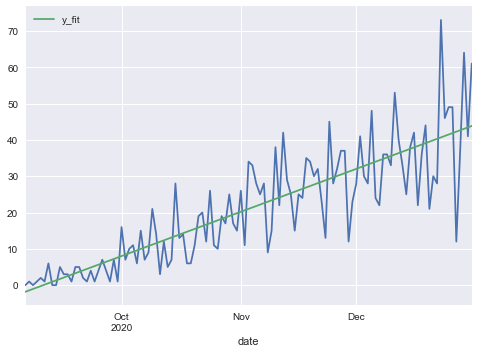

In [124]:
t1='2020-09-6'
t2='2020-12-31'
y1,fit_df1,reg1=regression(df1,1,t1,t2,col)


fig1,ax1=plt.subplots()
y1.plot(ax=ax1)
fit_df1.plot(ax=ax1)

reg1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         numdeathstoday   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     2.113
Date:                Wed, 27 Jan 2021   Prob (F-statistic):              0.160
Time:                        00:00:08   Log-Likelihood:                -102.54
No. Observations:                  24   AIC:                             209.1
Df Residuals:                      22   BIC:                             211.4
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -252.5943    211.941     -1.192      0.233    -667.992     162.803
N              0.9748      0.671      1.454      0.146      -0.340       2.289
==============================================================================
Omnibus:                        0.738   Durbin-Watson:                   1.439
Prob(Omnibus):                  0.691   Jarque-Bera (JB):                0.374
Skew:                           0.303   Prob(JB):                        0.829
Kurtosis:                       2.925   Cond. No.                     1.42e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

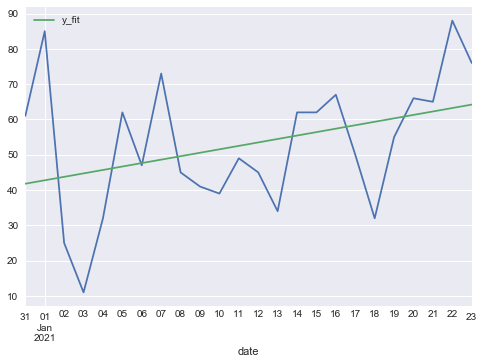

In [136]:
t1='2020-12-31'
t2='2021-01-23'
y2,fit_df2,reg2=regression(df1,1,t1,t2,col)

fig2,ax2=plt.subplots()
y2.plot(ax=ax2)
fit_df2.plot(ax=ax2)
reg2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         numdeathstoday   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     10.12
Date:                Tue, 26 Jan 2021   Prob (F-statistic):            0.00227
Time:                        23:58:15   Log-Likelihood:                -159.49
No. Observations:                  65   AIC:                             323.0
Df Residuals:                      63   BIC:                             327.3
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9885      3.260      3.985      0.000       6.600      19.377
N             -0.0635      0.020     -3.182      0.001      -0.103      -0.024
==============================================================================
Omnibus:                       18.304   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.812
Skew:                           1.211   Prob(JB):                     1.11e-05
Kurtosis:                       4.598   Cond. No.                     1.28e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

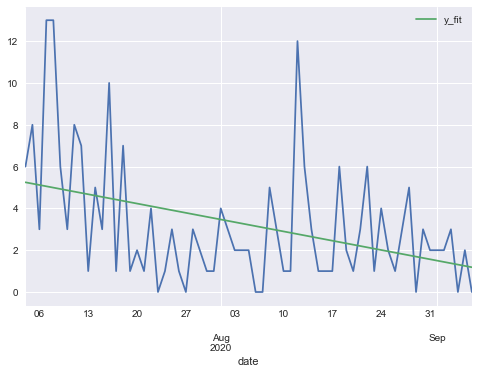

In [126]:
t3_1='2020-07-04'
t2_1='2020-09-06'
y3,fit_df3,reg3=regression(df1,1,t3_1,t2_1,col)

fig3,ax3=plt.subplots()
y3.plot(ax=ax3)
#ax3.plot(y3,'.')
fit_df3.plot(ax=ax3)

reg3.summary()



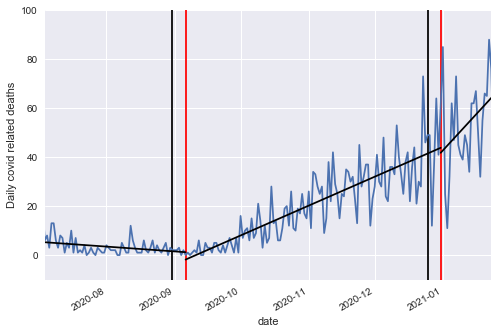

<Figure size 576x396 with 0 Axes>

In [127]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
df1.plot(ax=ax)


fit_df3.plot(ax=ax,color='k')
fit_df2.plot(ax=ax,color='k')
fit_df1.plot(ax=ax,color='k')

ax.legend([col],loc='upper left')
ax.set_yscale('linear')

ymin=df1.values.min()-50
ymax=df1.values.max()+50

ax.vlines('2020-03-20',ymin,ymax)
ax.vlines('2020-08-31',ymin,ymax)
ax.vlines('2020-12-25',ymin,ymax)


# The incubation time has a median of 5-6 days
#So the red lines is the important dates+ 6 days
ax.vlines('2020-03-26',ymin,ymax,color='r')
ax.vlines('2020-09-6',ymin,ymax,color='r')
ax.vlines('2020-12-31',ymin,ymax,color='r')

x1=pd.to_datetime(t3_1)
x2=pd.to_datetime('2021-01-23')

ax.set_xlim(x1,x2)
ax.set_ylim(-10,100)
ax.set_ylabel('Daily covid related deaths')
ax.get_legend().remove()
plt.show()
plt.savefig('fig2')

plt.show()
#The regressions 1,2,3 are not in order 

   #       3                       1                      2

In [128]:
#3    1     2

# The reopening of schools on 31/8/2020
#regression 3 from 2020-07-04' to 2020-09-06



#regression 1 from 2020-09-6 to 2020-12-31

#regression 2 from 2020-12-31 to 2021-01-23


print('jump in y values for both regession for2020-09-06')
print(((fit_df3.iloc[-1])-(fit_df1.iloc[0])).values[0],'\n')


print('jump in y values for both regession for 2020-12-31')
print(((fit_df1.iloc[-1])-(fit_df2.iloc[0])).values[0],'\n')
print('\n')

print('-------------------------------------')
print('slope of regression 3 from 2020-09-6 to 2020-12-31')
print(F'{reg3.params.N:.2f}\u00B1{reg3.bse.N:.2f}; p_value={reg3.pvalues.N}\n')

print('slope of regression 1 from 2020-09-6 to 2020-12-31')
print(F'{reg1.params.N:.2f}\u00B1{reg1.bse.N:.2f}; p_value={reg1.pvalues.N}\n')

print('slope of regression 2 from 2020-12-31 to 2021-01-23')
print(F'{reg2.params.N:.1f}\u00B1{reg2.bse.N:.1f}; p_value={reg2.pvalues.N}\n')



jump in y values for both regession for2020-09-06
3.0146892655367505 

jump in y values for both regession for 2020-12-31
2.0400738809215824 



-------------------------------------
slope of regression 3 from 2020-09-6 to 2020-12-31
-0.06±0.02; p_value=0.0014627196918630275

slope of regression 1 from 2020-09-6 to 2020-12-31
0.39±0.03; p_value=2.1280044513453973e-47

slope of regression 2 from 2020-12-31 to 2021-01-23
1.0±0.7; p_value=0.146069285986469



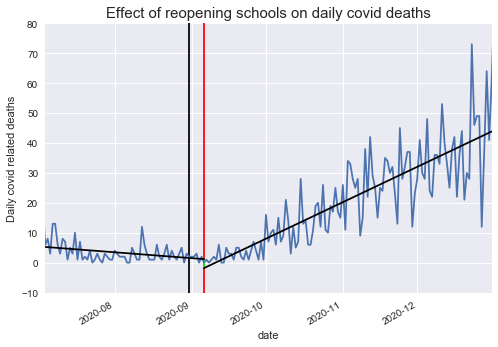

In [129]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
df1.plot(ax=ax)


fit_df3.plot(ax=ax,color='k')
fit_df1.plot(ax=ax,color='k')

ax.set_yscale('linear')

ymin=df1.values.min()-50
ymax=df1.values.max()+50

ax.vlines('2020-08-31',ymin,ymax)

# The incubation time has a median of 5-6 days
#So the red lines is the important dates+ 6 days
ax.vlines('2020-09-6',ymin,ymax,color='r')


ax.vlines('2020-09-6',
ymin=fit_df3.iloc[-1].values,
ymax=fit_df1.iloc[0].values
,color='lime')

x1=pd.to_datetime(t3_1)
x2=pd.to_datetime('2020-12-31')

ax.set_xlim(x1,x2)
ax.set_ylim(-10,80)
ax.set_ylabel('Daily covid related deaths')
ax.get_legend().remove()
ax.set_title('Effect of reopening schools on daily covid deaths',fontsize=15)
plt.show()

plt.show()


Part I



For this figure, we have the regression 3 witch is the linear regression before the reopening of schools (left) and the regression 1 witch is the linear regression after the reopening of schools (right)

-Justification on the design of the regressions:

The black vertical line represents the date the school reopened and the red line is 6 days after that date. The reason why we chose 6 days is that the incubation time of the virus has a median of 5-6 days. It is not an easy task to find the exact date where the effect of both the reopening of school and the lockdown will have an impact on the number of covid related death because there is no specific time interval between the contraction of the virus and death for the people who died from the virus, but 6 days after the reopening of school we can see the effect of the reopening of school and daily covid related deaths.

I choose the data from 2020-07-04 to 2020-09-06 for the regression 3 because we can see in that time interval that the number of daily death could be approximated as being linear in that interval which is also why I used a 1st-degree regression for that time interval. For the regression 1, I used the data from 2020-09-6 to 2020-12-31, I used the data between the reopening of school and the 2nd lockdown because I wanted to compare the slope of that time interval with the interval after the 2nd lockdown (I will discuss it in part II) for this time interval I also used a linear regression because we can see that the evolution of the number of daily death is linear. The R^2 is higer for a deg 2 for the regession 3 (0.225 vs 0.152), but it looks more linear, so a deg 2 could be an over fit for this regression. For the regression 1, we have a R^2 of 0.703 vs 0.704 for a deg 2, but the linear regression is still a better model. 


-Coefficient and p_values:

For the regression 3 (left) the value of the coefficient ( the slope ) is (-0.06±0.02) daily covid related deaths per day with a p_value of 0.0014627196918630275 (<5%) which means that the result is statistically significant so we can be confident about the result obtained by this regression. For the regression 1 (right) the value of the coefficient ( the slope ) is (0.39±0.03) daily covid related deaths per day with a p_value of 2.1280044513453973e-47 witch is a low p-value (<5%) which also means that the result is statistically significant so we can be confident about the result obtained by this regression.

-Findings for that event:

We can see a change in slope in those 2 regressions and the most important part of that change is the change in the sign between the 2 slopes. For the regression 3 ( left) we have a slope of -0.06±0.02 witch means that for every 100 days, there are 6 ± 2 deaths. The slope is close to 0 which means that it is almost stable. After the reopening of school, the slope has a value of (0.39±0.03) witch means that the number of covid related death has increased. The rate has increased by 0.45.

The jump of the y value. In this graph, the jump of the y value is represented by the green line. The value of that jump is 3.




0.45

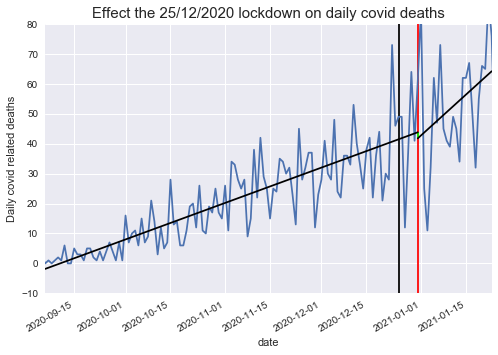

In [130]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
df1.plot(ax=ax)


fit_df1.plot(ax=ax,color='k')
fit_df2.plot(ax=ax,color='k')

ax.set_yscale('linear')

ymin=df1.values.min()-50
ymax=df1.values.max()+50


# The incubation time has a median of 5-6 days
#So the red lines is the important dates+ 6 days

x1=pd.to_datetime('2020-09-6')
x2=pd.to_datetime('2021-01-23')

ax.set_xlim(x1,x2)
ax.set_ylim(-10,80)
ax.set_ylabel('Daily covid related deaths')
ax.get_legend().remove()
ax.set_title('Effect the 25/12/2020 lockdown on daily covid deaths',fontsize=15)
ax.vlines('2020-12-25',ymin,ymax)



ax.vlines('2020-12-31',ymin,ymax,color='r')
ax.vlines('2020-12-31',
ymin=fit_df1.iloc[-1].values,
ymax=fit_df2.iloc[0].values
,color='lime')

plt.show()

plt.show()

Part 2



For this figure, we have the regression 1 witch is the linear regression discussed in part I and the regression 2 after  the 25/12/2020 lockdown   (right)

-Justification on the design of the regressions:

The black vertical line represents the date of the  25/12/2020 lockdown and the red line is 6 days after that date. The reason why we chose 6 days is still the median of the incubation time.

I choose the data from 31/12/2020 to 2021-01-23 for the regression 2.  For the regression 1, I used the same time interval that I used in part I. For the regression 2 it is hard to see the degree of the regression that we will use. The R^2 is higher for a deg 2 for the regression 2 (0.131 vs 0.255), and it is not easy to see if it is linear or not. I chose a linear fit even who the AIC and BIC are smaller for deg 2 for the regression 2 so it would be easier to compare it to regression 1. 


-Coefficient and p_values:
For regression 2 (right) the value of the coefficient ( the slope ) is (1.0±0.7) daily covid related deaths per day with a p_value of 0.146069285 (>5%) which means that the result is statistically insignificant so we can't be confident about the result obtained by this regression but we see that even with the std err, the slope is still >0 witch means the number of covid related deaths are still increasing. For the regression 1 (left) the value of the coefficient ( the slope ) is (0.39±0.03) daily covid related deaths per day with a p_value of 2.1280044513453973e-47 witch is a low p-value (<5%) which also means that the result is statistically significant so we can be confident about the result obtained by this regression.

-Findings for that event:
with this result, we can see that the number of Covid related deaths are still increasing even after the lockdown. There are many things that could cause this. Here are 2 hypotheses. Maybe people did not respect the lockdown and still went to visit family members. 2, the recorded deaths are the deaths related to the people who got sick before the lockdown.

The jump of the y value. In this graph, the jump of the y value is represented by the green line. The value of that jump is 2.
